In [456]:
#(thlu = theta leg upper, thll = theta leg lower)


%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thlu,thll = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg_upper}','\\theta_{leg_lower}']) 
dx,dy,dthb,dthlu,dthll = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg_upper}','\dot{\\theta}_{leg_lower}']) 
ddx,ddy,ddthb,ddthlu,ddthll = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg_upper}','\ddot{\\theta}_{leg_lower}']) 

q = sym.Matrix([[x],[y],[thb],[thlu],[thll]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthlu],[dthll]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthlu],[ddthll]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tau_hip,tau_knee,GRFx,GRFy = sym.symbols(['\\tau_hip','\\tau_knee','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - 0.5*ll1*sym.cos(thb + thlu)],
                [y - 0.5*ll1*sym.sin(thb + thlu)],
                [thb + thlu]])

rl2 = sym.Matrix([[x - ll1*sym.cos(thb + thlu)-(0.5*ll2)*sym.cos(thb + thlu+thll)],
                [y - ll1*sym.sin(thb + thlu)-(0.5*ll2)*sym.sin(thb + thlu+thll)],
                [thb + thlu+thll]])



# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau_hip]])
tau_l1 = sym.Matrix([[0],[0],[tau_hip - tau_knee]])
tau_l2 = sym.Matrix([[0],[0],[tau_knee]])

# F_l1 = sym.Matrix([[-F*sym.sin(thb+thlu)],[F*sym.cos(thb+thlu)],[0]])
# F_l2 = sym.Matrix([[+F*sym.cos(thb+thlu+thll)],[F*sym.sin(thb+thlu+thll)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[(0.5*ll2*sym.sin(thb+thlu+thll)*GRFx) - (0.5*ll2*sym.cos(thb+thlu+thll)*GRFy)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1).transpose()*Jl1[:,j]+(GRF_l2+tau_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [457]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thlu,thll,
            dx,dy,dthb,dthlu,dthll,
            ddx,ddy,ddthb,ddthlu,ddthll,
            tau_hip,tau_knee,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thlu = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_thll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [458]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_lu','theta_ll'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)

In [459]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [460]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
#         L = 0.5*m.len[('leg',1)]  + 0.5*m.len[('leg',2)] # total leg length
#         thA = m.q[n,'theta_b'] + m.q[n,'theta_lu'] + m.q[n,'theta_ll'] # absolute leg angle
        thA=(m.q[n,'theta_b'] + m.q[n,'theta_lu'])
        thB=(m.q[n,'theta_b'] +m.q[n,'theta_lu']+ m.q[n,'theta_ll'])

        return m.footp[n,dof] ==  m.q[n,'y'] - (m.len[('leg',1)]*sin(thA))-(m.len[('leg',2)]*sin(thB))
        
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)

# lambdify the foot velocity
thA=(thb + thlu)
thB=(thb + thlu + thll)

#footx = sym.Matrix([x + (0.5*ll1+0.5*ll2)*sym.sin(thb + thlu + thll)])
footx = sym.Matrix([x - (ll1*sym.cos(thA))-(ll2*sym.cos(thB))])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

In [461]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [0,np.pi]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [-np.pi/2,np.pi/2]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_lu'].setlb(hip_bound[0])
    m.q[n,'theta_lu'].setub(hip_bound[1])
    m.q[n,'theta_ll'].setlb(hip_bound[0])
    m.q[n,'theta_ll'].setub(hip_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
m.tau_r1 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.tau_b = Var(m.N, bounds = (-2,2)) # actuator torque at knee
m.tau_r2 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque


# m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
# m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# # complementarity
# def hip_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT angle
#             return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_lu']-m.q[n+1,'theta_ll'])*m.tau_r1[n,'ng']
#         else:
#             return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_lu'] + m.q[n+1,'theta_ll']- m.hip_bound['lo'])*m.tau_r1[n,'ps']
#     else:
#         return Constraint.Skip
# m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

# def knee_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT distance
#             return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] )*m.F_r[n,'ng']
#         else:
#             return m.joint_penalty[n,'knee',jc] == ( - m.knee_bound['lo'])*m.F_r[n,'ps']
#     else:
#         return Constraint.Skip
# m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

# #bound contact forces at last node
# for sgn in signs:
#     m.F_r[N,sgn].value = 0
#     m.F_r[N,sgn].fixed = True

for sgn in signs:
    m.tau_r1[N,sgn].value = 0
    m.tau_r1[N,sgn].fixed = True
    m.tau_r2[N,sgn].value = 0
    m.tau_r2[N,sgn].fixed = True

In [462]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))       #time constraint
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:             #ground constraints
            penalty_sum += m.ground_penalty[n,gc] #ground constraints  
#         for jc in joint_constraints:              #hard stop constraints
#             for j in joints:                       #hard stop constraints
#                 penalty_sum += m.joint_penalty[n,j,jc] #hard stop constraints
    return T+1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [463]:
# def CostFun(m):
#     torque_sum = 0
#     for n in range(1,N+1):
#             torque_sum += m.tau_a[n]**2
#     return torque_sum
# m.Cost = Objective(rule = CostFun)

In [464]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thlu(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thlu(*var_list) == 0
m.EOM_thlu = Constraint(m.N, rule = EOM_thlu)

def EOM_thll(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n]  - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
    tau_knee= S*(m.tau_b[n]  - m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])    
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thll(*var_list) == 0
m.EOM_thll = Constraint(m.N, rule = EOM_thll)

In [465]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 30.0
m.q[1,'theta_b'].value = 0.0
m.q[1,'theta_lu'].value = np.pi/2
m.q[1,'theta_ll'].value = 0.0

m.ddq[1,'theta_b'].value = 0.0
m.ddq[1,'theta_b'].fixed = True
m.ddq[1,'theta_lu'].value = 0.0
m.ddq[1,'theta_lu'].fixed = True
m.ddq[1,'theta_ll'].value = 0.0
m.ddq[1,'theta_ll'].fixed = True



for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
 
    
for n in range(1,N+1):
#     m.F_a[n].value = 0.0
#     m.F_a[n].fixed = True
    m.tau_a[n].value = 0.0
    m.tau_a[n].fixed = True
    m.tau_b[n].value = 0.0
    m.tau_b[n].fixed = True
    
    m.tau_r1[n,'ps'].value = 0.0
    m.tau_r1[n,'ps'].fixed = True
    m.tau_r1[n,'ng'].value = 0.0
    m.tau_r1[n,'ng'].fixed = True

    m.tau_r2[n,'ps'].value = 0.0
    m.tau_r2[n,'ps'].fixed = True
    m.tau_r2[n,'ng'].value = 0.0
    m.tau_r2[n,'ng'].fixed = True

    
# m.q[N,'x'].value = 0.0
# m.q[N,'y'].value = 0.0
# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
    
#m.pprint()


In [466]:
# # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# guide = np.linspace(0,5.0,N)
# for n in range(1,N+1):
#     m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#     m.q[n,'y'].value  = np.random.uniform(0,3)
#     m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/2,np.pi/2)
#     m.q[n,'theta_lu'].value  = np.random.uniform(0,np.pi)
#     m.q[n,'theta_ll'].value  = np.random.uniform(-np.pi/2,np.pi/2)
    
#     m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#     m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

In [467]:
# # SPRINT --------------------------------------------------------------------------------------------------------------------
# # tax day

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_lu'].value = np.pi/2
# m.q[1,'theta_ll'].value = 0.0

# m.q[1,'x'].fixed = True
# m.q[1,'theta_b'].fixed = True
# m.q[1,'theta_lu'].fixed = True
# m.q[1,'theta_ll'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
      
# # final condition
# m.q[N,'x'].setlb(5.0)

# m.dq[N,'x'].value = 0.0
# m.dq[N,'x'].fixed = 0.0
# m.dq[N,'theta_b'].value = 0.0
# m.dq[N,'theta_b'].fixed = 0.0
# m.dq[N,'theta_lu'].value = 0.0
# m.dq[N,'theta_lu'].fixed = 0.0
# m.dq[N,'theta_ll'].value = 0.0
# m.dq[N,'theta_ll'].fixed = 0.0

# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
# m.q[N,'theta_b'].fixed = True
# m.q[N,'theta_lu'].fixed = True
# m.q[N,'theta_ll'].fixed = True

# m.footp[N,'Y'].value = 0.0
# m.footp[N,'Y'].fixed = True
    
# #m.pprint()

In [468]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    13367
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5930

Total number of variables............................:     2684
                     variables with only lower bounds:     1196
                variables with lower and upper bounds:      298
                     variables with only 

 284r 2.0121357e+05 5.16e-01 5.50e+01  -3.8 1.31e+01    -  1.00e+00 5.28e-02h  2
 285r 2.0112918e+05 5.16e-01 2.92e+01  -3.8 1.02e+01    -  1.00e+00 5.58e-02h  4
 286r 2.0111190e+05 5.16e-01 2.87e+01  -3.8 9.04e+00    -  1.00e+00 1.36e-02h  6
 287r 2.0110370e+05 5.16e-01 2.99e+01  -3.8 8.53e+00    -  1.00e+00 7.41e-03h  7
 288r 2.0109980e+05 5.16e-01 3.17e+01  -3.8 7.93e+00    -  1.00e+00 4.40e-03h  8
 289r 2.0098270e+05 5.16e-01 2.78e+01  -3.8 7.34e+00    -  1.00e+00 1.75e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 2.0061925e+05 5.15e-01 5.03e+00  -3.8 5.68e+00    -  1.00e+00 8.29e-01H  1
 291r 2.0061112e+05 5.15e-01 8.59e+00  -3.8 7.59e-01    -  1.00e+00 4.53e-01h  1
 292r 2.0059109e+05 5.15e-01 1.15e-01  -3.8 4.12e-01    -  1.00e+00 1.00e+00h  1
 293r 2.0058329e+05 5.15e-01 1.32e+01  -3.8 2.07e-02    -  7.84e-01 1.00e+00h  1
 294r 2.0058314e+05 5.15e-01 3.53e-01  -3.8 1.16e-02    -  1.00e+00 1.00e+00h  1
 295r 2.0058339e+05 5.15e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 3.0538887e+05 4.80e-01 1.83e+01  -5.6 1.58e+01  -3.4 7.22e-02 1.19e-01h  1
 381r 3.0644571e+05 4.80e-01 1.37e+01  -5.6 4.08e+00  -3.0 2.55e-02 1.22e-01h  1
 382r 3.0670386e+05 4.80e-01 1.64e+01  -5.6 2.26e-01  -1.7 4.73e-02 2.23e-01h  1
 383r 3.0690373e+05 4.80e-01 1.08e+01  -5.6 5.50e-01  -2.2 5.41e-01 1.07e-01f  1
 384r 3.0937790e+05 4.80e-01 5.54e+00  -5.6 1.67e+00  -2.6 5.87e-02 6.36e-01h  1
 385r 3.1505858e+05 4.80e-01 7.87e+00  -5.6 1.99e+03    -  1.56e-03 1.91e-03f  1
 386r 3.1659338e+05 4.80e-01 9.22e+00  -5.6 1.02e+02    -  5.82e-03 9.74e-03h  1
 387r 3.1737173e+05 4.80e-01 7.64e+00  -5.6 7.70e+01    -  1.28e-02 6.17e-03h  1
 388r 3.1735735e+05 4.80e-01 7.58e+00  -5.6 1.46e+01    -  3.78e-02 6.87e-02h  1
 389r 3.1740179e+05 4.80e-01 4.38e+01  -5.6 3.34e+00  -3.1 2.58e-01 1.11e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 3.1801901e+05 4.80e-01

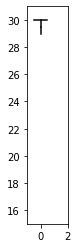

In [440]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,2])
    ax.set_ylim([15,31])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*cos(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*sin(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB= m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value+m.q[i,'theta_ll'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb-m.len[('leg',2)]*cos(thB)    
    leg2_yb = leg1_yb-m.len[('leg',2)]*sin(thB)     
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [470]:
for n in range(1,N+1):
    #print(m.dq[n,'theta_lu'].value)
    print(m.tau_r2[n,'ng'].value)
    
#print(m.dq[1,'theta_lu'].value)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [427]:
sym.printing.latex(EOM[1].simplify())

'- 1.0 G_{y} - 0.5 \\ddot{\\theta}_{body} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{body} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{body} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_lower} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} + 1.0 \\ddot{y} m_{body} + 1.0 \\ddot{y} m_{leg1} + 1.0 \\ddot{y} m_{leg2} + 0.5 \\dot{\\theta}_{body}^{2} l_{leg1} m_{leg1} \\sin{\\left(\\theta_{body}